In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

import h5py as h5
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

alph = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
        'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 
        'u', 'v', 'w', 'x', 'y', 'z', 'aa']

mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [4]:
def load_galaxy(sim, sd=None, idx=320):
    if sim=='iso':
        key = 'lvl4-Ngb64'
        output_dir = basepath + 'runs/MW7iso/'+ key + '/output'
    elif sd is not None:
        key = 'lvl4-sd'+str(sd)
        output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    else:
        key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
        output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    return galaxy.Galaxy(output_dir, idx, orient=True)

In [5]:
allgal = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgal[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgal[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgal[Rs][Vv][ecc] = load_galaxy(sim)
            
allgal['iso'] = load_galaxy('iso')

100%|██████████| 3/3 [01:06<00:00, 22.03s/it]


In [6]:
def extract_sim_data(gal, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        mask = np.full_like(in_SN, True)
    else:
        mask = in_SN
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(mask, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[mask]
    out['logMgFe'] = logMgFe[mask]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[mask]
    out['BirthMass'] = sn.part4.GFM_InitialMass[mask]
    # out['Pos'] = sn.part4.Coordinates[mask]
    # out['BirthPos'] = sn.part4.BirthPos[mask]
    out['in_SN'] = in_SN
    
    # load com as fn of time
    # time, com0, com1 = find_com(sd)
    # com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'_seed'+str(sd)+'.npy', allow_pickle=True).item()
    # out['COM'] = {}
    # for k in com.keys():
        # out['COM'][k] = com[k]
    
    return out

In [23]:
allsimdat = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allsimdat[Rs] = {}
    for Vv in ['116', '129', '142']:
        allsimdat[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allsimdat[Rs][Vv][ecc] = extract_sim_data(allgal[Rs][Vv][ecc], no_SN=True)

allsimdat['iso'] = extract_sim_data(allgal['iso'], no_SN=True)

100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


In [8]:
def construct_gmm(dat, logFeH0=0, dlogFeH=0.1, no_SN=False):
    """
    Analyze peaks in the logMgFe data and determine if the data prefers 2 modes over 1 mode.

    Parameters:
        dat (dict): Dictionary containing simulated data.
        logFeH0 (float): Central logFeH value to filter data around.
        dlogFeH (float): Range of logFeH to filter data.
        no_SN (bool): If True, exclude SN filtering.

    Returns:
        preferred_gmm (GaussianMixture): The GMM model (1 or 2 modes) preferred by BIC.
        prefers_two_modes (bool): True if BIC suggests 2 modes are preferred over 1 mode.
        bic_diff (float): Difference in BIC between the 1-mode and 2-mode models.
    """
    # Extract the data
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    
    if not no_SN:
        logFeH = logFeH[dat['in_SN']]
        logMgFe = logMgFe[dat['in_SN']]
    
    # Filter data based on logFeH
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2, logFeH < logFeH0 + dlogFeH / 2)
    data = logMgFe[key].reshape(-1, 1)

    # Fit Gaussian Mixture Models with 1 and 2 components
    gmm_1 = GaussianMixture(n_components=1, random_state=0)
    gmm_2 = GaussianMixture(n_components=2, random_state=0)
    gmm_1.fit(data)
    gmm_2.fit(data)

    # Compute BIC for both models
    bic_1 = gmm_1.bic(data)
    bic_2 = gmm_2.bic(data)
    bic_diff = bic_1 - bic_2  # Positive if 2 modes are preferred

    # Determine which GMM is preferred
    prefers_two_modes = bic_diff > 0

    return gmm_1, gmm_2, prefers_two_modes, bic_diff


def calculate_overlap(mean1, std1, mean2, std2):
    """
    Calculate the overlap between two Gaussian distributions.
    
    Parameters:
        mean1, std1: Mean and standard deviation of the first Gaussian.
        mean2, std2: Mean and standard deviation of the second Gaussian.
        
    Returns:
        overlap (float): The overlap between the two distributions.
    """
    def pdf1(x):
        return norm.pdf(x, loc=mean1, scale=std1)
    
    def pdf2(x):
        return norm.pdf(x, loc=mean2, scale=std2)
    
    def min_pdf(x):
        return np.minimum(pdf1(x), pdf2(x))
    
    # Integrate the minimum of the two PDFs
    overlap, _ = quad(min_pdf, -np.inf, np.inf)
    return overlap

def bimodality_metric(gmm, t=0.1, k=20):
    """
    Calculate a bimodality metric based on the ratio of the less prominent mode's peak 
    to the trough between the two modes, adjusted by the ratio of mode weights.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
    
    Returns:
        bimodality_score (float): The calculated bimodality metric.
    """
    def weight_penalty(w2, t, k):
        return 1 / (1 + np.exp(-k * (w2 - t)))
    
    if len(gmm.means_.flatten())==1:
        return 0.0
    
    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_

    # Ensure components are ordered by mean
    order = np.argsort(means)
    means = means[order]
    variances = variances[order]
    weights = weights[order]

    # Calculate the peaks (heights of the modes)
    peaks = weights / np.sqrt(2 * np.pi * variances)
    less_prominent_peak = min(peaks)

    # Find the trough: point between means where the GMM density is minimized
    x_trough = np.linspace(means[0], means[1], 1000)
    densities = np.exp(gmm.score_samples(x_trough.reshape(-1, 1)))
    trough_density = densities.min()
    trough_point = x_trough[np.argmin(densities)]

    # Compute the weight ratio (smaller weight divided by larger weight)
    # weight_ratio = min(weights) / max(weights)
    # weight_ratio = 1

    # Compute the bimodality metric, scaling by the weight ratio
    # bimodality_score = (less_prominent_peak / trough_density) * weight_ratio
    
    bimodality_score = np.abs(means[1] - means[0]) / np.sqrt(np.sum(variances))
    bimodality_score *= weight_penalty(min(weights), t, k)
    
    # bimodality_score = np.abs(means[0] - means[1])
    return bimodality_score, trough_point

# Example usage:
# Assuming `simdat` is defined and contains the appropriate data
# gmm = construct_gmm(simdat[2], logFeH0=0.0, dlogFeH=0.1)
# bimodality_metric(gmm)

In [9]:
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']

bim_metric = []
ordered_sim = []
allgmm = []
trough_point = []

for i,Rs in enumerate(Rs_list):
    for j,Vv in enumerate(Vv_list):
        for k,ecc in enumerate(ecc_list):
            simdat = allsimdat[Rs][Vv][ecc]
            
            _, gmm, _, _ = construct_gmm(simdat, logFeH0=0.0, dlogFeH=0.1, no_SN=False)
            # bim_metric.append(bic_diff)
            
            bm_, tp_ = bimodality_metric(gmm)
            
            bim_metric.append(bm_)
            trough_point.append(tp_)
            ordered_sim.append((Rs, Vv, ecc))
            allgmm.append(gmm)

# Sorting both bim_metric and ordered_sim based on bim_metric values
sorted_data = sorted(zip(bim_metric, trough_point, ordered_sim, allgmm), key=lambda x: x[0])

# Unzipping the sorted data back into separate lists
bim_metric, trough_point, ordered_sim, allgmm = zip(*sorted_data)

# Converting back to lists if needed
bim_metric = list(bim_metric)
trough_point = list(trough_point)
ordered_sim = list(ordered_sim)
allgmm = list(allgmm)

In [10]:
from scipy.signal import argrelmin

129 129 04 a 0.2880888530540707 nan
129 116 04 b 0.34998144737379205 nan
116 116 04 c 0.7716293661722311 nan
142 116 05 d 0.7939937049697606 nan
142 129 06 e 0.8896338540204352 nan
116 129 04 f 1.122393729909555 nan
116 116 05 g 1.248209474471725 nan
116 142 04 h 1.338941812590866 nan
142 142 05 i 1.429580009572426 nan
129 142 05 j 1.456608064489768 nan
142 129 04 k 1.617593989479247 nan
142 142 06 l 1.7501545529041285 nan
116 129 05 m 1.8219018447886826 nan
129 129 05 n 1.9553352812806053 nan
129 116 05 o 2.04065556742531 nan
116 116 06 p 2.1605748444154402 nan
116 129 06 q 2.2395535778193048 nan
142 129 05 r 2.2563161550897943 0.28250000000000014
142 116 04 s 2.5239067197909835 0.31250000000000017
116 142 06 t 2.5946595818152245 0.2575000000000001
116 142 05 u 2.6177317255012036 0.29250000000000015
142 116 06 v 2.6457123193530325 0.27250000000000013
129 142 06 w 2.662121415049872 0.28750000000000014
142 142 04 x 2.695414083073675 0.28250000000000014
129 116 06 y 2.9386819572920637 0.

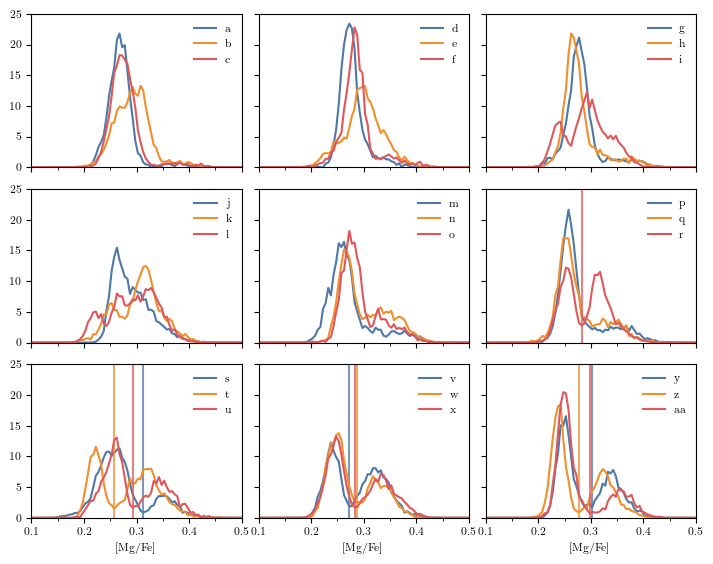

In [159]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True, sharey=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0.1, 0.5 + 0.01, 0.005)

# Iterate over 3x3 panels
k = 0
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            
            # if Rs=='142' and Vv=='116' and ecc=='04':
                # print(i, j, k)
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            
            # Plot histogram
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=alph[k]+' '+str(round(bim, 3)))
            y, edges = np.histogram(logMgFe[mask], bins=bins, density=True)
            x = 0.5*(edges[1:] + edges[:-1])
            ax.plot(x, y, label=r'$\textrm{'+alph[k]+r'}$', c=c)
            
            # print(k)
            if bim > 2.25:
                # ax.axvline(trough_point[k], c=c, alpha=0.75)
                # minidx = argrelmin(y)
                # trpt_cand = x[minidx]
                # trpt = trpt_cand[np.logical_and(trpt_cand > 0.25, trpt_cand < 0.35)]
                # assert len(trpt)==1
                # print(len(trpt))
                # ax.axvline(trpt, c=c, alpha=0.75)
                
                mask_trpt = np.logical_and(x > 0.25, x < 0.35)
                trpt = x[mask_trpt][np.argmin(y[mask_trpt])]
                ax.axvline(trpt, c=c, alpha=0.75)
                trough_point[k] = trpt
            else:
                trough_point[k] = np.nan
            
            print(Rs, Vv, ecc, alph[k], bim_metric[k], trough_point[k])
            
            k += 1
        
        ax.set(xlim=(0.1, 0.5), ylim=(0, 25))
        ax.set_xticks(np.arange(0.1, 0.5+0.05, 0.05), minor=True)
        ax.legend(frameon=False)

for ax in axs[2]:
    ax.set_xlabel(r'$[\textrm{Mg}/\textrm{Fe}]$')
        
fig.tight_layout()
fig.savefig('paper_plots/hist.pdf')


In [14]:
np.histogram(np.random.rand(1000), bins=np.linspace(0, 1, 100), density=True)

(array([1.188, 1.386, 0.99 , 0.99 , 1.386, 0.891, 1.089, 0.99 , 0.99 ,
        0.693, 0.792, 0.396, 0.693, 0.99 , 0.495, 1.287, 1.683, 0.99 ,
        0.99 , 0.99 , 0.792, 0.891, 1.386, 0.792, 0.594, 0.891, 1.287,
        0.693, 1.188, 0.99 , 0.693, 0.891, 0.297, 0.99 , 1.287, 1.188,
        1.188, 1.089, 1.287, 1.188, 0.99 , 0.396, 0.792, 0.891, 0.99 ,
        0.891, 1.089, 1.287, 0.891, 0.891, 0.792, 0.891, 0.891, 0.594,
        1.188, 1.188, 0.99 , 0.99 , 1.188, 1.188, 0.495, 1.287, 0.891,
        1.188, 1.089, 1.089, 1.188, 0.792, 0.396, 1.485, 1.287, 0.693,
        0.693, 1.188, 1.089, 0.693, 0.99 , 1.287, 0.891, 0.594, 1.188,
        0.99 , 1.089, 1.584, 1.188, 1.287, 1.089, 1.287, 1.287, 1.089,
        1.584, 0.99 , 0.693, 0.792, 0.792, 0.693, 0.891, 1.683, 0.99 ]),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.151

# alpha vs time gaussian fit

In [39]:
def get_gaussian_fit(simdat, dt=0.2, logFeH0 = 0, dlogFeH = 0.1, no_SN=False):
    tform   = simdat['GFM_StellarFormationTime']
    logMgFe = simdat['logMgFe']
    logFeH  = simdat['logFeH']
    
    mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    if not no_SN:
        mask = np.logical_and(mask, simdat['in_SN'])
    
    tbins = np.arange(0, 8+dt, dt)
    tcen = 0.5 * (tbins[1:] + tbins[:-1])
    
    mu_list = []
    sigma_list = []
    amp_list = []
    
    for t0 in tbins[:-1]:
        mask_att0 = np.logical_and(tform > t0, tform < t0 + dt)
        mask_att0 = np.logical_and(mask, mask_att0)
        
        amp = np.sum(mask_att0)
        if amp > 10:
            mu, sigma = norm.fit(logMgFe[mask_att0])
        else:
            mu, sigma = np.nan, np.nan
        
        mu_list.append(mu)
        sigma_list.append(sigma)
        amp_list.append(amp)
    
    out = {}
    out['tcen'] = np.array(tcen)
    out['tbins'] = np.array(tbins)
    out['mu'] = np.array(mu_list)
    out['sigma'] = np.array(sigma_list)
    out['amp'] = np.array(amp_list)
    
    return out

In [40]:
allgaussfit = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgaussfit[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgaussfit[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgaussfit[Rs][Vv][ecc] = get_gaussian_fit(allsimdat[Rs][Vv][ecc], no_SN=False)

allgaussfit['iso'] = get_gaussian_fit(allsimdat['iso'])

100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


done!


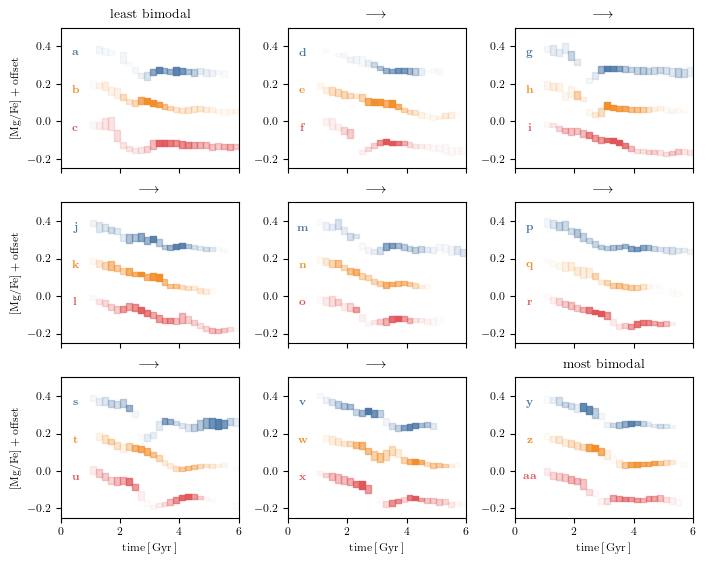

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
l = 0
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        offset = 0.
        doffset = -0.2
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            gfit = allgaussfit[Rs][Vv][ecc]
            # ax.plot(gfit['tcen'], gfit['mu'], c=c)

            # print(alph[l], np.max(gfit['amp'][tcen < 5]))
            
            tbins = gfit['tbins']
            tcen = gfit['tcen']
            # amp_norm = gfit['amp'] / np.max(gfit['amp'][tcen < 5])
            amp_norm = np.minimum(gfit['amp']/650, 1.)
            
            # amp_norm = np.minimum(gfit['amp']/3000, 1.)
            # print(alph[l], np.max(gfit['amp'][tcen < 6]))
            # amp_norm[amp_norm>1] = 1
            mu_plus_sigma  = gfit['mu'] + gfit['sigma'] + offset
            mu_minus_sigma = gfit['mu'] - gfit['sigma'] + offset

            for k in range(len(tbins) - 1):
                ax.fill_between(
                    tbins[k:k+2], 
                    mu_minus_sigma[k:k+1], 
                    mu_plus_sigma[k:k+1], 
                    color=c, 
                    alpha=amp_norm[k]
                )
            
                ax.set(xlim=(0, 6), ylim=(0.15-0.4, 0.5))
            
            
            ax.text(0.5, 0.35+offset, r'$\textrm{\textbf{'+alph[l]+r'}}$', c=c, ha='center')
            
            offset += doffset
            l += 1
        
for ax in axs[2]:
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')

for ax in axs[:,0]:
    ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
    
# for ax in axs[:,0]:
    # ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
for ax in axs.ravel():
    ax.set(title=r'$\longrightarrow$')

axs[0][0].set(title=r'$\textrm{least bimodal}$')
axs[2][2].set(title=r'$\textrm{most bimodal}$')

fig.tight_layout()
# fig.savefig('gauss_fit.pdf')
# plt.close(fig)
print('done!')

done!


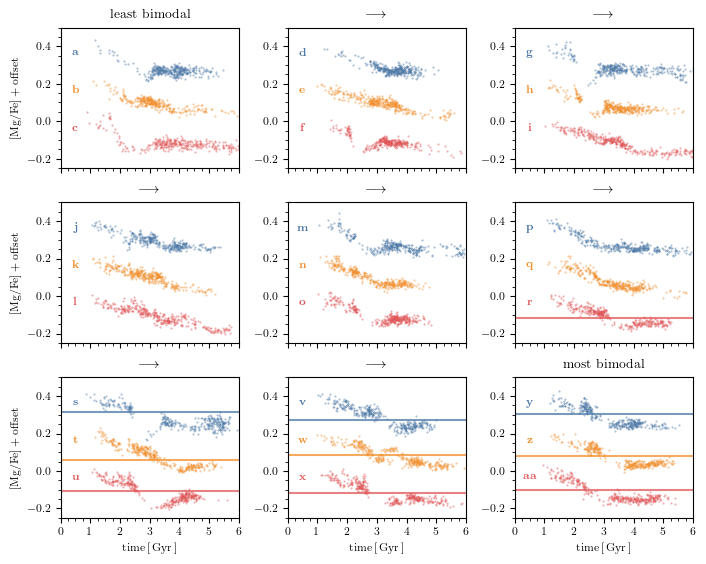

In [160]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
l = 0
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        ax.set(xlim=(0, 6), ylim=(0.15-0.4, 0.5))
        ax.set(xticks=np.arange(0, 6+1, 1))
        ax.set_xticks(np.arange(0, 6+0.25, 0.25), minor=True)
        ax.set_yticks(np.arange(-0.25, 0.5+0.05, 0.05), minor=True)
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        offset = 0.
        doffset = -0.2
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            simdat = allsimdat[Rs][Vv][ecc]
            tform   = simdat['GFM_StellarFormationTime']
            logMgFe = simdat['logMgFe']
            logFeH  = simdat['logFeH']
    
            mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
            mask = np.logical_and(mask, simdat['in_SN'])
            
            # print(Rs, Vv, ecc, np.sum(mask))
            keys = np.random.choice(np.where(mask)[0], 350, replace=False)
            ax.scatter(tform[keys], logMgFe[keys]+offset, c=c, s=0.25, alpha=0.5)
            
            ax.text(0.5, 0.35+offset, r'$\textrm{\textbf{'+alph[l]+r'}}$', c=c, ha='center')
            
            if bim > 2.25:
                ax.axhline(trough_point[l] + offset, c=c, alpha=0.75)
            
            offset += doffset
            l += 1
        
for ax in axs[2]:
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')

for ax in axs[:,0]:
    ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
    
# for ax in axs[:,0]:
    # ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
for ax in axs.ravel():
    ax.set(title=r'$\longrightarrow$')

axs[0][0].set(title=r'$\textrm{least bimodal}$')
axs[2][2].set(title=r'$\textrm{most bimodal}$')

fig.tight_layout()
fig.savefig('paper_plots/scatter.pdf')
# plt.close(fig)
print('done!')

In [53]:
np.random.choice(np.where(mask)[0], 1000, replace=False).shape

(1000,)

# tot sfr

done!


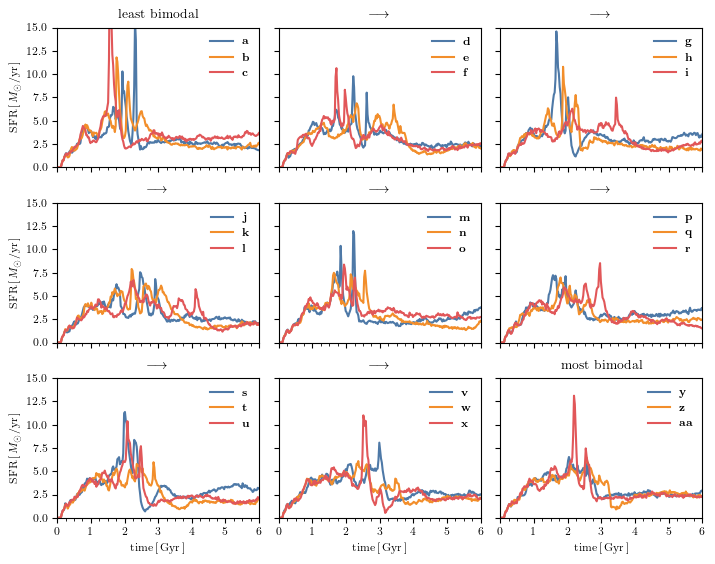

In [28]:
from scipy.stats import binned_statistic
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True, sharey=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
l = 0
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        # ax.set_yticks(np.arange(-0.25, 0.5+0.05, 0.05), minor=True)
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            simdat = allsimdat[Rs][Vv][ecc]
            tform   = np.copy(simdat['GFM_StellarFormationTime'])
            Mform   = np.copy(simdat['BirthMass'])
            
            Mform *= 1e10

            tbins = np.arange(0, 8+0.025, 0.025)
            dt = tbins[1] - tbins[0]
            dt *= 1e9
            sfh, bin_edges, _ = binned_statistic(tform, Mform/dt, bins=tbins, statistic='sum')
            tcen = 0.5*(bin_edges[1:] + bin_edges[:-1])
            
            # print(Rs, Vv, ecc, np.sum(mask))
            ax.plot(tcen, sfh, c=c, label=r'$\textrm{\textbf{'+alph[l]+r'}}$')
            
            l += 1
        
        ax.set(xlim=(0, 6), ylim=(0, 15))
        ax.set(xticks=np.arange(0, 6+1, 1))
        ax.set_xticks(np.arange(0, 6+0.25, 0.25), minor=True)
        ax.legend(frameon=False)
        
for ax in axs[2]:
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')

for ax in axs[:,0]:
    ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    
for ax in axs.ravel():
    ax.set(title=r'$\longrightarrow$')

axs[0][0].set(title=r'$\textrm{least bimodal}$')
axs[2][2].set(title=r'$\textrm{most bimodal}$')

fig.tight_layout()
fig.savefig('paper_plots/sfh.pdf')
print('done!')

## repeat test

363797 361797 363797 361797


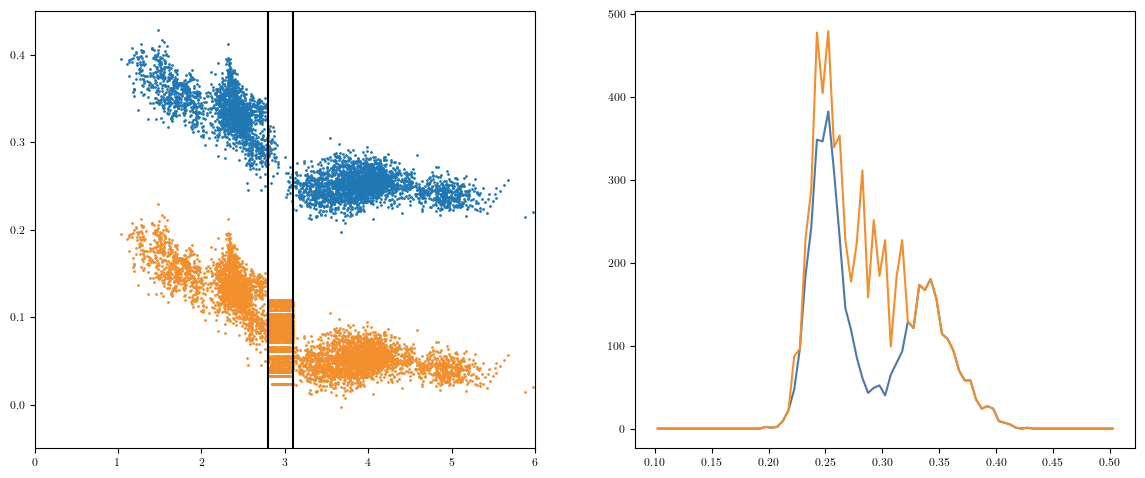

In [132]:
Rs, Vv, ecc = ('129', '116', '06')
np.random.seed(42)
simdat = allsimdat[Rs][Vv][ecc]
fig, axs = plt.subplots(1, 2, figsize=(2*textwidth, 0.8*textwidth))

logFeH0 = 0
dlogFeH = 0.1
t0, t1 = 2.8, 3.1

logFeH = simdat['logFeH']
logMgFe = simdat['logMgFe']
tform = simdat['GFM_StellarFormationTime']

mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
mask = np.logical_and(mask, simdat['in_SN'])

axs[0].scatter(tform[mask], logMgFe[mask], s=1)

offset = -0.2

tform_rs = np.copy(tform)
logMgFe_rs = np.copy(logMgFe)
Nextra = 2000
mask_int0t1 = np.logical_and(mask, np.logical_and(tform_rs > t0, tform_rs < t1))

logMgFe_extra = np.random.choice(logMgFe[mask_int0t1], Nextra, replace=True)
tform_extra = np.random.uniform(t0, t1, Nextra)

tform_rs = np.concatenate([tform, tform_extra])
logMgFe_rs = np.concatenate([logMgFe, logMgFe_extra])
mask_rs = np.concatenate([mask, np.full(Nextra, True, dtype=bool)])

print(len(tform_rs), len(tform), len(mask_rs), len(mask))

axs[0].scatter(tform_rs[mask_rs], logMgFe_rs[mask_rs]+offset, s=1, c=tb_c[1])

axs[0].set(xlim=(0, 6), ylim=(-0.05, 0.45))
axs[0].axvline(t0, c='k')
axs[0].axvline(t1, c='k')

bins = np.arange(0.1, 0.5 + 0.01, 0.005)

y, edges = np.histogram(logMgFe[mask], bins=bins)
x = 0.5*(edges[1:] + edges[:-1])
axs[1].plot(x, y, c=tb_c[0])

y, edges = np.histogram(logMgFe_rs[mask_rs], bins=bins)
x = 0.5*(edges[1:] + edges[:-1])
axs[1].plot(x, y, c=tb_c[1])


(0.15, 0.45)

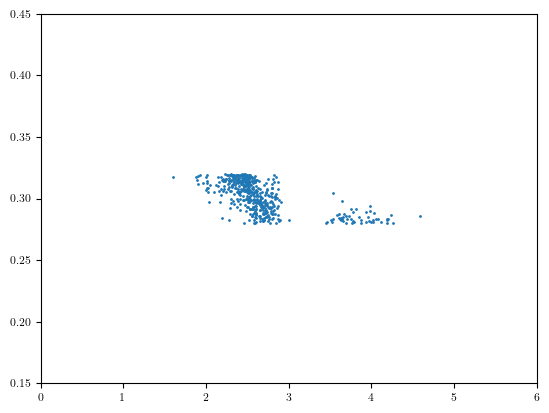

In [106]:
mask_byalpha = np.logical_and(mask, np.logical_and(logMgFe > 0.28, logMgFe < 0.32))
plt.scatter(tform[mask_byalpha], logMgFe[mask_byalpha], s=1)
plt.xlim(0, 6)
plt.ylim(0.15, 0.45)

In [107]:
def get_gaussian_fit(simdat, dt=0.2, logFeH0 = 0, dlogFeH = 0.1):
    tform   = simdat['GFM_StellarFormationTime']
    logMgFe = simdat['logMgFe']
    logFeH  = simdat['logFeH']
    
    mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    mask = np.logical_and(mask, simdat['in_SN'])
    
    tbins = np.arange(0, 8+dt, dt)
    tcen = 0.5 * (tbins[1:] + tbins[:-1])
    
    mu_list = []
    sigma_list = []
    amp_list = []
    
    for t0 in tbins[:-1]:
        mask_att0 = np.logical_and(tform > t0, tform < t0 + dt)
        mask_att0 = np.logical_and(mask, mask_att0)
        
        amp = np.sum(mask_att0)
        if amp > 10:
            mu, sigma = norm.fit(logMgFe[mask_att0])
        else:
            mu, sigma = np.nan, np.nan
        
        mu_list.append(mu)
        sigma_list.append(sigma)
        amp_list.append(amp)
    
    out = {}
    out['tcen'] = np.array(tcen)
    out['tbins'] = np.array(tbins)
    out['mu'] = np.array(mu_list)
    out['sigma'] = np.array(sigma_list)
    out['amp'] = np.array(amp_list)
    
    return out

In [108]:
gauss_fit = get_gaussian_fit(simdat)

(0.0, 6.0)

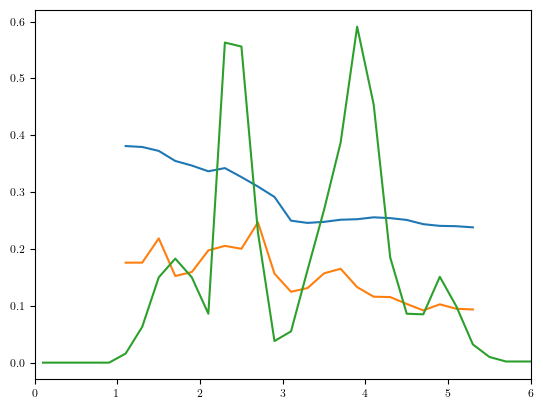

In [119]:
plt.plot(gauss_fit['tcen'], gauss_fit['mu'])
plt.plot(gauss_fit['tcen'], gauss_fit['sigma']*10)
plt.plot(gauss_fit['tcen'], gauss_fit['amp']/1000)
plt.xlim(0, 6)

In [129]:
mu_sample = np.interp(2.8, gauss_fit['tcen'], gauss_fit['mu'])
sigma_sample = np.interp(2.8, gauss_fit['tcen'], gauss_fit['sigma'])

In [130]:
mu_sample

0.30056977272033697

(array([  2.,   0.,   0.,   2.,   1.,   2.,   4.,   6.,  11.,  10.,  20.,
         28.,  45.,  41.,  74.,  91., 123., 114., 131., 148., 179., 183.,
        177., 207., 200., 190., 192., 176., 188., 212., 181., 187., 229.,
        229., 273., 337., 317., 346., 387., 394., 445., 494., 428., 476.,
        457., 477., 470., 412., 453., 463., 404., 426., 344., 335., 304.,
        269., 229., 246., 199., 184., 147., 145., 142., 135.,  91., 107.,
         75.,  67.,  63.,  55.,  58.,  37.,  41.,  39.,  29.,  24.,  25.,
         26.,  26.,  19.,  14.,  10.,  11.,  17.,   8.,  15.,   9.,   7.,
          4.,   6.,   5.,   0.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.19725126, 0.19956803, 0.2018848 , 0.20420156, 0.20651833,
        0.2088351 , 0.21115187, 0.21346864, 0.21578541, 0.21810217,
        0.22041894, 0.22273571, 0.22505248, 0.22736925, 0.22968601,
        0.23200278, 0.23431955, 0.23663632, 0.23895309, 0.24126986,
        0.24358662, 0.24590339, 0.24822016, 0.

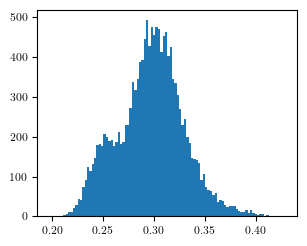

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))

Nextra = 10000
logMgFe_extra = np.random.normal(mu_sample, sigma_sample, Nextra)
logMgFe_rs = np.concatenate([logMgFe[mask], logMgFe_extra])
plt.hist(logMgFe_rs, bins=100)